# Simulation settings

In [1]:
L = 8
J = 1
h = 0.05
lamb = 0.5

particle_pair_left_position = 3
particle_pair_length = 1

final_time = 1
layers = 10
measure_every_layers = 1

# Device selection

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance

channel = "ibm_quantum"
device = "ibm_brussels"

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

# Circuit transpilation

Longest circuit contains 280 CNOT gates


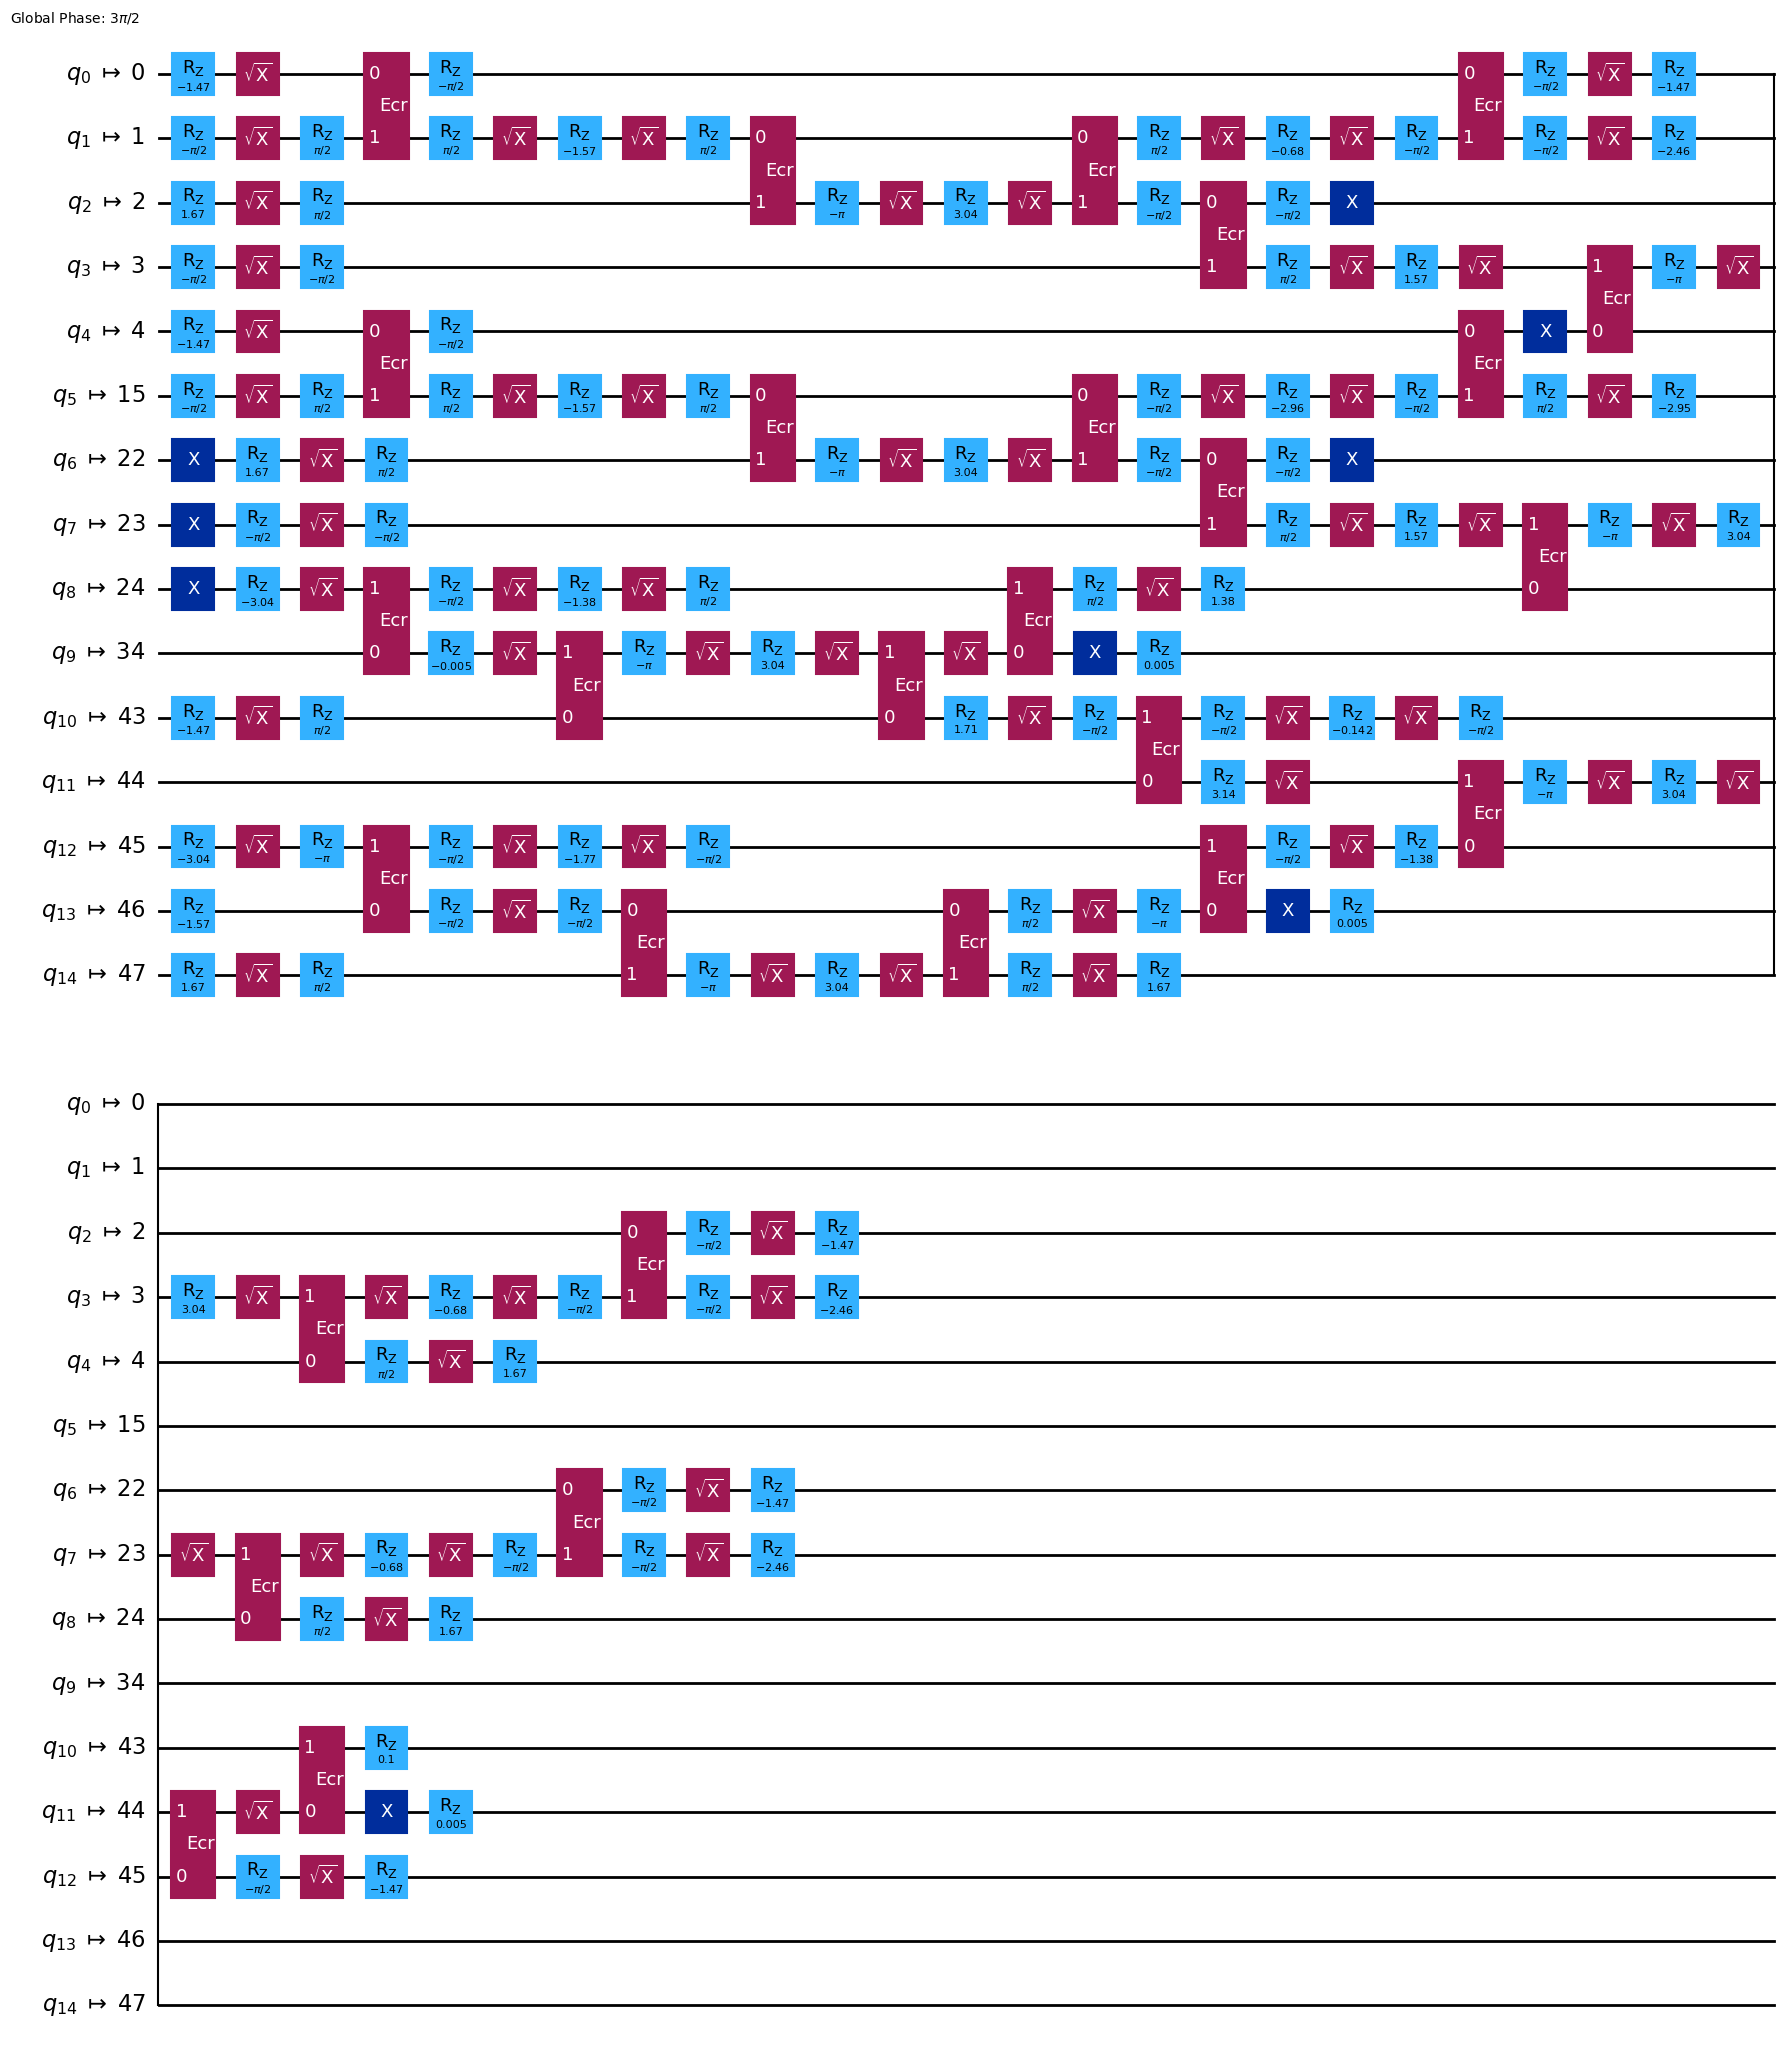

In [3]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

# qubits_inds = None
qubits_inds = [0, 1, 2, 3, 4, 15, 22, 23, 24, 34, 
               43, 44, 45, 46, 47, 48, 49, 55, 68, 67,
               66, 65, 64, 63, 62, 72, 81, 82, 83, 92,
               102, 101, 100, 99, 98, 97, 96, 109, 114, 115,
               116, 117, 118, 119, 120]

physical_circuits = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, measure_every_layers=measure_every_layers)
print(f"Longest circuit contains {physical_circuits[-1].num_nonlocal_gates()} CNOT gates")
physical_circuits[1].draw(output="mpl", idle_wires=False)

# Estimator circuit execution

### Options

In [4]:
from utils.hexec import execdb

default_shots = 4096
optimization_level = 0 # Deactivate error suppression
resilience_level = 0 # Deactivate error mitigation
execution_database = "z2_chain_jobs.json"
zne_mitigation = "linear"
measure_mitigation = True
dynamical_decoupling = "XY4"

zne_mitigation_dict = {"none": "",
                       "linear": r"linear",
                       "quadratic": r'polynomial_degree_2',
                       "exponential": r"exponential"}

estimator_options = {
    "default_shots": default_shots,
    "optimization_level": optimization_level,
    "resilience_level": resilience_level,
    "resilience": {
        "zne_mitigation": bool(zne_mitigation_dict[zne_mitigation]),
        "measure_mitigation": measure_mitigation
    },
    "dynamical_decoupling": {
        "enable": bool(dynamical_decoupling),
        "sequence_type": dynamical_decoupling
    },
    # "twirling": {
    #     "enable_gates": True,
    #     "num_randomizations": 32,
    #     "shots_per_randomization": 100
    # }
}

if bool(zne_mitigation_dict[zne_mitigation]):
    estimator_options["resilience"]["zne"] = {"extrapolator": zne_mitigation_dict[zne_mitigation]}

job_db = execdb(execution_database)

### Observables to measure

In [5]:
from z2chain.qiskit_observables import local_pauli_z
from functools import partial

observable_name = "Occupation numbers"
observable_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]

### Send job to hardware

In [6]:
jobs = job_db.execute_estimator_batch(backend, estimator_options, physical_circuits, observable_generating_funcs, observable_name)

### Load last job with the same options

In [10]:
jobs = job_db.search_by_params(estimator_options, physical_circuits, observable_name, strict_depth=False, limit=1, ibmq_service=service)

# Post-selected circuit execution

In [1]:
from utils.hexec import execdb

default_shots = 8192
execution_database = "z2_chain_postselected_jobs.json"
dynamical_decoupling = "XY4"

sampler_options = {
    "default_shots": default_shots,
    "dynamical_decoupling": {
        "enable": bool(dynamical_decoupling),
        "sequence_type": dynamical_decoupling
    },
    "twirling": {
        "enable_gates": True,
        "num_randomizations": 32,
        "shots_per_randomization": 100
    }
}

job_db = execdb(execution_database)

# Plots

### Quech plot

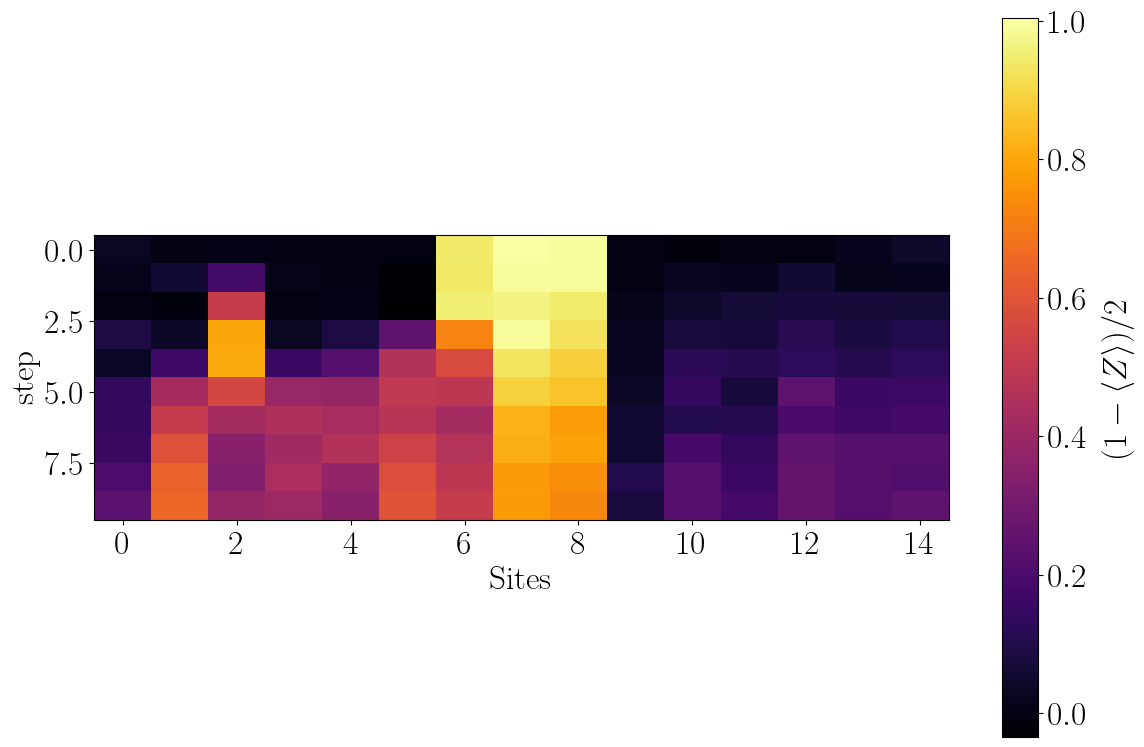

In [11]:
from z2chain.plotting import x_t_plot

x_t_plot(jobs, f"Plots/hardware_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_zne_{zne_mitigation}_mm_{measure_mitigation}_dc_{dynamical_decoupling}.png")

### Comparison with circuit tensor network simulation

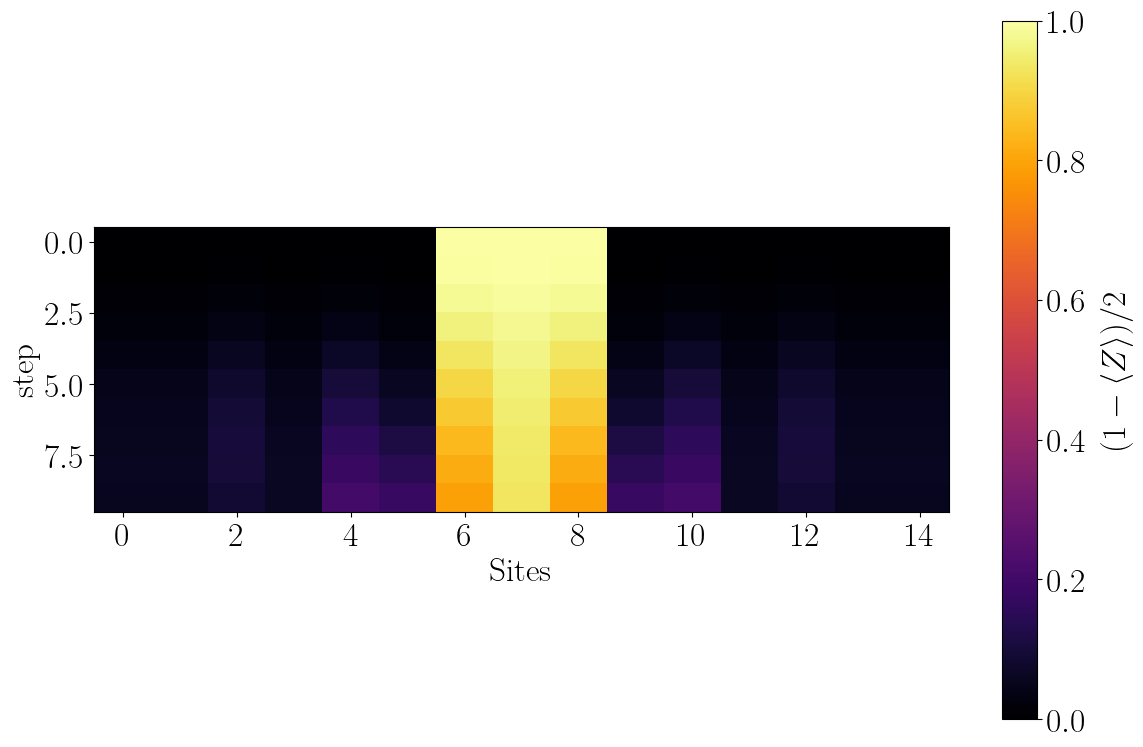

In [22]:
from z2chain.plotting import x_t_plot, save_site_gauge_observable_matrix, load_site_gauge_observable_matrix
from z2chain.circs import particle_pair_quench_simulation_circuits
from utils.sexec import execute_simulation_estimator_batch
import os

estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-8,
    "max_parallel_threads": 8,
    "max_parallel_experiments": 8
}

filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_bd_{mps_simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{estimator_options['default_precision']}.txt"

if os.path.exists(filepath):
    tn_site_gauge_observable_matrix = load_site_gauge_observable_matrix(filepath)
else:
    logical_circs = particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, measure_every_layers)
    observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]
    tn_site_gauge_observable_matrix = execute_simulation_estimator_batch(mps_simulator_options, estimator_options, logical_circs, observables_generating_funcs)
    save_site_gauge_observable_matrix(tn_site_gauge_observable_matrix, filepath)

x_t_plot(tn_site_gauge_observable_matrix)

In [ ]:
from z2chain.plotting import discrepancies_plot

discrepancies_plot(tn_site_gauge_observable_matrix, jobs)